# CNN 遥感图像分类项目

## 数据说明
This is a 21 class land use image dataset meant for research purposes. 
There are 100 images for each of the following classes:
+ agricultural
+ airplane
+ baseballdiamond
+ beach
+ buildings
+ chaparral
+ denseresidential
+ forest
+ freeway
+ golfcourse
+ harbor
+ intersection
+ mediumresidential
+ mobilehomepark
+ overpass
+ parkinglot
+ river
+ runway
+ sparseresidential
+ storagetanks
+ tenniscourt

Each image measures 256x256 pixels.

The images were manually extracted from large images from the USGS National Map Urban Area Imagery collection for various urban areas around the country. The pixel resolution of this public domain imagery is 1 foot.

Download site: http://weegee.vision.ucmerced.edu/datasets/landuse.html

## 项目任务

图像分类

1. 研读所提供代码 
2. 读取原始图像并进行预处理
3. 实现CNN architecture 
4. 在空白处完善代码

# 1. 读取原始数据和文件

## Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

from tensorflow import keras
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D
from tensorflow.keras.layers import GlobalAveragePooling2D, AveragePooling2D
from tensorflow.keras.layers import ZeroPadding2D, Dropout, Flatten, add, Reshape
from tensorflow.keras.layers import Activation, BatchNormalization
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.utils import plot_model,to_categorical
from tensorflow.keras import backend as K
from tensorflow.keras import initializers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

from skimage.transform import resize
import cv2

from PIL import Image
import os
from shutil import copyfile

In [2]:
#!pip freeze 

In [3]:
print(keras.__version__)

2.4.0


In [4]:
category_names = [
    'agricultural',
    'forest',
    'mobilehomepark',
    'overpass',
    'parkinglot',
    'river',
    'runway',
    'sparseresidential'
]

In [5]:
num_images = 100  # per category
nb_classes = len(category_names)
patch_size = 256  # width and height in pixel
channels = 3

In [6]:
# Load the numpy datasets
images_orig = np.load('data/UCMerced_images_orig_MultiClass.npy')
labels_num = np.load('data/UCMerced_labels_num_MultiClass.npy')

# Convert labels to categorical 'one hot encoded vector' --> required format for softmax cross-entropy loss.
# Create an array of zeros with length nb_classes and put a 1 at the index of the true label.
labels = to_categorical(labels_num, nb_classes)

print('Orginal Labels: \n')
for i in range(1,(nb_classes)*100+1, 100):
    print(labels_num[i])

print('One-hot encoded Labels: \n')
for i in range(1,(nb_classes)*100+1, 100):
    print(labels[i])

print('\nImages shape: {}'.format(images_orig.shape))
print('\nLabel shape: {}'.format(labels.shape))

Orginal Labels: 

[0]
[1]
[2]
[3]
[4]
[5]
[6]
[7]
One-hot encoded Labels: 

[1. 0. 0. 0. 0. 0. 0. 0.]
[0. 1. 0. 0. 0. 0. 0. 0.]
[0. 0. 1. 0. 0. 0. 0. 0.]
[0. 0. 0. 1. 0. 0. 0. 0.]
[0. 0. 0. 0. 1. 0. 0. 0.]
[0. 0. 0. 0. 0. 1. 0. 0.]
[0. 0. 0. 0. 0. 0. 1. 0.]
[0. 0. 0. 0. 0. 0. 0. 1.]

Images shape: (800, 64, 64, 3)

Label shape: (800, 8)


# 2. Split train, val and test

In [7]:
nb_images = images_orig.shape[0]
nb_images

800

In [8]:
X_train, X_test, y_train, y_test = train_test_split(images_orig, labels, 
                                                    test_size=0.2, 
                                                    stratify = labels, 
                                                    random_state=2021)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, 
                                                  test_size=0.25, 
                                                  stratify = y_train,
                                                  random_state=2021) 

# 0.25 x 0.8 = 0.2

In [9]:
print(X_train.shape,X_val.shape,X_test.shape,y_train.shape,y_val.shape,y_test.shape,)

(480, 64, 64, 3) (160, 64, 64, 3) (160, 64, 64, 3) (480, 8) (160, 8) (160, 8)


Check how many images per class in train/val/test

In [10]:
def unique_counts(arr):
    unique, counts = np.unique(arr, axis=0, return_counts=True)
    unique_num = [np.where(r==1)[0][0] for r in unique] 
    print(dict(zip(unique_num, counts)))

In [11]:
unique_counts(y_train)
unique_counts(y_val)
unique_counts(y_test)

{7: 60, 6: 60, 5: 60, 4: 60, 3: 60, 2: 60, 1: 60, 0: 60}
{7: 20, 6: 20, 5: 20, 4: 20, 3: 20, 2: 20, 1: 20, 0: 20}
{7: 20, 6: 20, 5: 20, 4: 20, 3: 20, 2: 20, 1: 20, 0: 20}


# 3. Build CNN Model

Kernel 64 for 1st Conv layer, and 128 for 2nd Conv layer.

Add one more dense layer with 32 nodes. 

In [12]:
# parameters:
input_shape = (int(patch_size/4), int(patch_size/4), channels)
pool_size = (2, 2)                  # size of pooling area for max pooling
prob_drop_hidden = 0.5              # drop probability for dropout @ dense layer

def define_CNN_base():
    model = Sequential()
    # conv1 layer
    model.add(Conv2D(filters=64, 
                     kernel_size=(3,3),  
                     activation='relu', 
                     padding = 'same',
                     input_shape=input_shape))    
    
    model.add(MaxPooling2D(pool_size=pool_size, strides=(2, 2)))

    # conv2 layer
    model.add(Conv2D(filters=128, 
                     kernel_size=(3,3),  
                     activation='relu', 
                     padding = 'same',
                   ))    
    model.add(MaxPooling2D(pool_size=pool_size, strides=(2, 2)))
    
    # conv3 layer
    model.add(Conv2D(filters=256, 
                     kernel_size=(3,3),  
                     activation='relu', 
                     padding = 'same',
                   )) 
    model.add(MaxPooling2D(pool_size=pool_size, strides=(2, 2)))

    model.add(Flatten())

    # fc1 layer
    model.add(Dense(128, activation='relu'))

    # fc2 layer
    model.add(Dense(64, activation='relu'))

    # The output of the model (softmax)
    model.add(Dense(nb_classes, activation='softmax'))
    return model

def define_CNN_Dropout():
    model = Sequential()

    # conv1 layer
    model.add(Conv2D(filters=64, 
                     kernel_size=(3,3),  
                     activation='relu', 
                     padding = 'same',
                     input_shape=input_shape))    
    
    model.add(MaxPooling2D(pool_size=pool_size, strides=(2, 2)))

    # conv2 layer
    model.add(Conv2D(filters=128, 
                     kernel_size=(3,3),  
                     activation='relu', 
                     padding = 'same',
                   ))    
    model.add(MaxPooling2D(pool_size=pool_size, strides=(2, 2)))
    
    # conv3 layer
    model.add(Conv2D(filters=256, 
                     kernel_size=(3,3),  
                     activation='relu', 
                     padding = 'same',
                   )) 
    model.add(MaxPooling2D(pool_size=pool_size, strides=(2, 2)))


    model.add(Flatten())

    # fc1 layer
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(rate=prob_drop_hidden))

    # fc2 layer
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(rate=prob_drop_hidden))

    # The output of the model (softmax)
    model.add(Dense(nb_classes, activation='softmax'))
    return model


In [13]:
# clear the session first, such that layer names start with index 1
K.clear_session()
model_CNN_base = define_CNN_base()

In [14]:
# clear the session first, such that layer names start with index 1
K.clear_session()
model_CNN_Dropout= define_CNN_Dropout()

In [15]:
model_CNN_base.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 64, 64, 64)        1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 128)       73856     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 256)       295168    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 8, 8, 256)         0         
_________________________________________________________________
flatten (Flatten)            (None, 16384)             0

In [16]:
model_CNN_Dropout.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 64, 64, 64)        1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 128)       73856     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 256)       295168    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 8, 8, 256)         0         
_________________________________________________________________
flatten (Flatten)            (None, 16384)             0

# 4. Train the base model

#### What is epoch
Number epoch equal to the number of times the algorithm sees the entire data set. So, each time the algorithm has seen all samples in the dataset, one epoch has completed.

#### What is batch size
Batch size is the number of items from the data to takes the training model. If you use the batch size of one you update weights after every sample. If you use batch size 32, you calculate the average error and then update weights every 32 items.

For instance, let’s say you have 24000 training samples and you want to set up a batch size equal to 32. The algorithm takes the first 32 samples from the training dataset and trains the network. Next, it takes the second 32 samples and trains the network again. We can keep doing this procedure until we have propagated all samples through the network.

#### What is iteration
Every time you pass a batch of data through the neural network, you completed one iteration. In the case of neural networks, that means the forward pass and backward pass. So, batch size * number of iterations = epoch

Iterative calculations on a portion of the data to save time and computational resources.

#### Epoch vs iteration
One epoch includes all the training examples whereas one iteration includes only one batch of training examples.


In general, a batch size of 32 is a good starting point, and you should also try with 64, 128, and 256. 

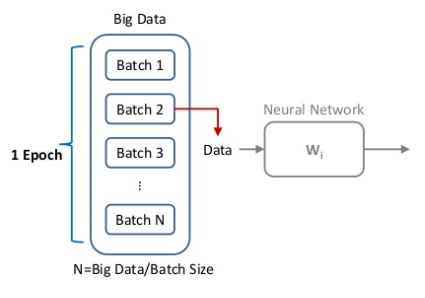

In [17]:
def train_model(model, checkpoint_name):
    # Set hyper parameters
    epochs = 500
    base_learning_rate=0.0001
    batch_size = 32
    # Define an optimizer
    opt = Adam(lr=base_learning_rate)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])       
    checkpoint_best_model = checkpoint_name

    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=80)
    mc = ModelCheckpoint(checkpoint_best_model, monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)
    # Fit the model parameters
    print('training base model...')

    history = model.fit(X_train, y_train, 
                        epochs=epochs, 
                        batch_size=batch_size,
                        verbose=2, 
                        validation_data=(X_val, y_val),                
                        callbacks=[es, mc]
                       )

    print('done')
    return model, history

In [18]:
model_DO = define_CNN_Dropout()
checkpoint_best_model_DO = 'model/MultiClass_3Conv2DenseDropout.hdf5'
model_DO, history_DO = train_model(model_DO, checkpoint_best_model_DO)    

training base model...
Epoch 1/500

Epoch 00001: val_accuracy improved from -inf to 0.12500, saving model to model\MultiClass_3Conv2DenseDropout.hdf5
15/15 - 4s - loss: 2.0880 - accuracy: 0.1229 - val_loss: 2.0620 - val_accuracy: 0.1250
Epoch 2/500

Epoch 00002: val_accuracy did not improve from 0.12500
15/15 - 4s - loss: 2.0710 - accuracy: 0.1229 - val_loss: 2.0592 - val_accuracy: 0.1250
Epoch 3/500

Epoch 00003: val_accuracy did not improve from 0.12500
15/15 - 4s - loss: 2.0506 - accuracy: 0.1458 - val_loss: 2.0380 - val_accuracy: 0.1250
Epoch 4/500

Epoch 00004: val_accuracy improved from 0.12500 to 0.22500, saving model to model\MultiClass_3Conv2DenseDropout.hdf5
15/15 - 4s - loss: 2.0515 - accuracy: 0.1437 - val_loss: 2.0136 - val_accuracy: 0.2250
Epoch 5/500

Epoch 00005: val_accuracy improved from 0.22500 to 0.23750, saving model to model\MultiClass_3Conv2DenseDropout.hdf5
15/15 - 4s - loss: 2.0077 - accuracy: 0.1792 - val_loss: 1.9605 - val_accuracy: 0.2375
Epoch 6/500

Epoch 

Epoch 47/500

Epoch 00047: val_accuracy did not improve from 0.66875
15/15 - 5s - loss: 1.1144 - accuracy: 0.6000 - val_loss: 1.0152 - val_accuracy: 0.6313
Epoch 48/500

Epoch 00048: val_accuracy did not improve from 0.66875
15/15 - 5s - loss: 1.0380 - accuracy: 0.6708 - val_loss: 0.8956 - val_accuracy: 0.6625
Epoch 49/500

Epoch 00049: val_accuracy improved from 0.66875 to 0.67500, saving model to model\MultiClass_3Conv2DenseDropout.hdf5
15/15 - 5s - loss: 1.0837 - accuracy: 0.5938 - val_loss: 0.9324 - val_accuracy: 0.6750
Epoch 50/500

Epoch 00050: val_accuracy improved from 0.67500 to 0.70000, saving model to model\MultiClass_3Conv2DenseDropout.hdf5
15/15 - 5s - loss: 1.0935 - accuracy: 0.6187 - val_loss: 0.9047 - val_accuracy: 0.7000
Epoch 51/500

Epoch 00051: val_accuracy did not improve from 0.70000
15/15 - 5s - loss: 1.0243 - accuracy: 0.6250 - val_loss: 0.8825 - val_accuracy: 0.7000
Epoch 52/500

Epoch 00052: val_accuracy did not improve from 0.70000
15/15 - 5s - loss: 1.0420 -

Epoch 97/500

Epoch 00097: val_accuracy did not improve from 0.78750
15/15 - 5s - loss: 0.4612 - accuracy: 0.8438 - val_loss: 0.5747 - val_accuracy: 0.7875
Epoch 98/500

Epoch 00098: val_accuracy improved from 0.78750 to 0.79375, saving model to model\MultiClass_3Conv2DenseDropout.hdf5
15/15 - 5s - loss: 0.5002 - accuracy: 0.8479 - val_loss: 0.5703 - val_accuracy: 0.7937
Epoch 99/500

Epoch 00099: val_accuracy did not improve from 0.79375
15/15 - 5s - loss: 0.5732 - accuracy: 0.8313 - val_loss: 0.6198 - val_accuracy: 0.7812
Epoch 100/500

Epoch 00100: val_accuracy did not improve from 0.79375
15/15 - 5s - loss: 0.5137 - accuracy: 0.8396 - val_loss: 0.5908 - val_accuracy: 0.7937
Epoch 101/500

Epoch 00101: val_accuracy did not improve from 0.79375
15/15 - 6s - loss: 0.5239 - accuracy: 0.8354 - val_loss: 0.6047 - val_accuracy: 0.7812
Epoch 102/500

Epoch 00102: val_accuracy did not improve from 0.79375
15/15 - 6s - loss: 0.5064 - accuracy: 0.8188 - val_loss: 0.6023 - val_accuracy: 0.7875

Epoch 148/500

Epoch 00148: val_accuracy did not improve from 0.85000
15/15 - 5s - loss: 0.2562 - accuracy: 0.9229 - val_loss: 0.4619 - val_accuracy: 0.8250
Epoch 149/500

Epoch 00149: val_accuracy did not improve from 0.85000
15/15 - 5s - loss: 0.2392 - accuracy: 0.9229 - val_loss: 0.5314 - val_accuracy: 0.7875
Epoch 150/500

Epoch 00150: val_accuracy did not improve from 0.85000
15/15 - 5s - loss: 0.2038 - accuracy: 0.9417 - val_loss: 0.5184 - val_accuracy: 0.8313
Epoch 151/500

Epoch 00151: val_accuracy did not improve from 0.85000
15/15 - 5s - loss: 0.2160 - accuracy: 0.9312 - val_loss: 0.5050 - val_accuracy: 0.8188
Epoch 152/500

Epoch 00152: val_accuracy did not improve from 0.85000
15/15 - 5s - loss: 0.2174 - accuracy: 0.9333 - val_loss: 0.5584 - val_accuracy: 0.8125
Epoch 153/500

Epoch 00153: val_accuracy did not improve from 0.85000
15/15 - 5s - loss: 0.2593 - accuracy: 0.9104 - val_loss: 0.5164 - val_accuracy: 0.8125
Epoch 154/500

Epoch 00154: val_accuracy did not improve f

Epoch 201/500

Epoch 00201: val_accuracy did not improve from 0.85000
15/15 - 6s - loss: 0.1835 - accuracy: 0.9417 - val_loss: 0.7168 - val_accuracy: 0.8250
Epoch 202/500

Epoch 00202: val_accuracy did not improve from 0.85000
15/15 - 6s - loss: 0.1779 - accuracy: 0.9375 - val_loss: 0.5024 - val_accuracy: 0.8313
Epoch 203/500

Epoch 00203: val_accuracy did not improve from 0.85000
15/15 - 5s - loss: 0.1896 - accuracy: 0.9312 - val_loss: 0.4917 - val_accuracy: 0.8250
Epoch 204/500

Epoch 00204: val_accuracy did not improve from 0.85000
15/15 - 6s - loss: 0.1426 - accuracy: 0.9563 - val_loss: 0.5155 - val_accuracy: 0.8188
Epoch 205/500

Epoch 00205: val_accuracy did not improve from 0.85000
15/15 - 5s - loss: 0.1401 - accuracy: 0.9479 - val_loss: 0.4777 - val_accuracy: 0.8375
Epoch 206/500

Epoch 00206: val_accuracy did not improve from 0.85000
15/15 - 5s - loss: 0.1133 - accuracy: 0.9750 - val_loss: 0.5113 - val_accuracy: 0.8375
Epoch 207/500

Epoch 00207: val_accuracy did not improve f

In [19]:
model_base = define_CNN_base()
checkpoint_best_model_base = 'model/MultiClass_3Conv2DenseBase.hdf5'
model_base, history_base = train_model(model_base, checkpoint_best_model_base)

training base model...
Epoch 1/500

Epoch 00001: val_accuracy improved from -inf to 0.12500, saving model to model\MultiClass_3Conv2DenseBase.hdf5
15/15 - 6s - loss: 2.0695 - accuracy: 0.1083 - val_loss: 2.0446 - val_accuracy: 0.1250
Epoch 2/500

Epoch 00002: val_accuracy did not improve from 0.12500
15/15 - 5s - loss: 2.0142 - accuracy: 0.1354 - val_loss: 1.9829 - val_accuracy: 0.1250
Epoch 3/500

Epoch 00003: val_accuracy improved from 0.12500 to 0.27500, saving model to model\MultiClass_3Conv2DenseBase.hdf5
15/15 - 5s - loss: 1.9300 - accuracy: 0.2062 - val_loss: 1.8777 - val_accuracy: 0.2750
Epoch 4/500

Epoch 00004: val_accuracy improved from 0.27500 to 0.28125, saving model to model\MultiClass_3Conv2DenseBase.hdf5
15/15 - 6s - loss: 1.8089 - accuracy: 0.2958 - val_loss: 1.7584 - val_accuracy: 0.2812
Epoch 5/500

Epoch 00005: val_accuracy improved from 0.28125 to 0.45625, saving model to model\MultiClass_3Conv2DenseBase.hdf5
15/15 - 6s - loss: 1.6601 - accuracy: 0.3750 - val_loss:

Epoch 49/500

Epoch 00049: val_accuracy did not improve from 0.76250
15/15 - 6s - loss: 0.1788 - accuracy: 0.9667 - val_loss: 0.8120 - val_accuracy: 0.7063
Epoch 50/500

Epoch 00050: val_accuracy did not improve from 0.76250
15/15 - 5s - loss: 0.1869 - accuracy: 0.9563 - val_loss: 0.8199 - val_accuracy: 0.7250
Epoch 51/500

Epoch 00051: val_accuracy did not improve from 0.76250
15/15 - 5s - loss: 0.1577 - accuracy: 0.9729 - val_loss: 0.7365 - val_accuracy: 0.7375
Epoch 52/500

Epoch 00052: val_accuracy did not improve from 0.76250
15/15 - 5s - loss: 0.1384 - accuracy: 0.9771 - val_loss: 0.7479 - val_accuracy: 0.7437
Epoch 53/500

Epoch 00053: val_accuracy did not improve from 0.76250
15/15 - 5s - loss: 0.1467 - accuracy: 0.9792 - val_loss: 0.8746 - val_accuracy: 0.7188
Epoch 54/500

Epoch 00054: val_accuracy did not improve from 0.76250
15/15 - 5s - loss: 0.2125 - accuracy: 0.9542 - val_loss: 0.8091 - val_accuracy: 0.7500
Epoch 55/500

Epoch 00055: val_accuracy did not improve from 0.7

Epoch 102/500

Epoch 00102: val_accuracy did not improve from 0.77500
15/15 - 10s - loss: 0.0266 - accuracy: 1.0000 - val_loss: 0.8031 - val_accuracy: 0.7437
Epoch 103/500

Epoch 00103: val_accuracy did not improve from 0.77500
15/15 - 10s - loss: 0.0229 - accuracy: 1.0000 - val_loss: 0.7917 - val_accuracy: 0.7688
Epoch 104/500

Epoch 00104: val_accuracy did not improve from 0.77500
15/15 - 9s - loss: 0.0185 - accuracy: 0.9979 - val_loss: 0.8162 - val_accuracy: 0.7437
Epoch 105/500

Epoch 00105: val_accuracy did not improve from 0.77500
15/15 - 9s - loss: 0.0178 - accuracy: 1.0000 - val_loss: 0.8170 - val_accuracy: 0.7688
Epoch 106/500

Epoch 00106: val_accuracy did not improve from 0.77500
15/15 - 9s - loss: 0.0218 - accuracy: 0.9958 - val_loss: 0.8211 - val_accuracy: 0.7563
Epoch 107/500

Epoch 00107: val_accuracy did not improve from 0.77500
15/15 - 9s - loss: 0.0189 - accuracy: 0.9979 - val_loss: 0.8053 - val_accuracy: 0.7625
Epoch 108/500

Epoch 00108: val_accuracy did not improve

Plotting training accuracy/loss curves

In [23]:
def history_plot(model_id, history1, history2):
	plt.figure(figsize=(14,16)) 
	# plot loss
	plt.subplot(2, 1, 1)
	plt.title('Cross Entropy Loss - ' + model_id, fontsize = 12)
	plt.plot(history1.history['loss'], color='blue', label='train base')
	plt.plot(history1.history['val_loss'], color='cyan', label='val base')
	plt.plot(history2.history['loss'], color='green',  ls=('dotted'), label='train DO')
	plt.plot(history2.history['val_loss'], color='red',  ls=('dotted'), label='val DO')
	plt.xlabel("Epochs",fontsize = 12)
	plt.ylabel("Loss", fontsize = 12)
	plt.legend(loc='upper right')

	# plot accuracy
	plt.subplot(2, 1, 2)
	plt.title('Classification Accuracy ' + model_id, fontsize = 10)
	plt.plot(history1.history['accuracy'], color='blue', label='train base')
	plt.plot(history1.history['val_accuracy'], color='cyan', label='val base')
	plt.plot(history2.history['accuracy'],  ls=('dotted'), color='green', label='train DO')
	plt.plot(history2.history['val_accuracy'], color='red', ls=('dotted'),  label='val DO')
	plt.xlabel("Epochs", fontsize = 12)
	plt.ylabel("Accuracy", fontsize = 12)
	plt.legend(loc='lower right')

	plt.show()

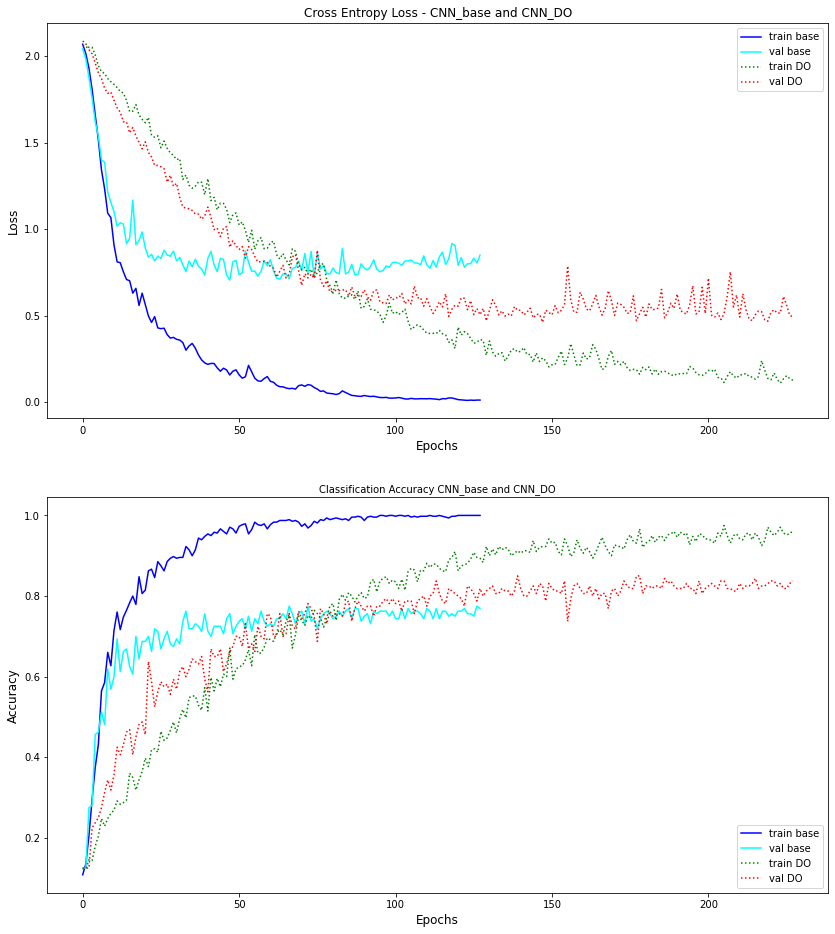

In [24]:
history_plot('CNN_base and CNN_DO', history_base, history_DO)

#### Saving our model to disk

A Keras model consists of multiple components:

+ An architecture, or configuration, which specifies what layers the model contain, and how they're connected.
+ A set of weights values (the "state of the model").
+ An optimizer (defined by compiling the model).
+ A set of losses and metrics (defined by compiling the model or calling add_loss() or add_metric()).
The Keras API makes it possible to save all of these pieces to disk at once, or to only selectively save some of them:

+ Saving everything into a single archive in the TensorFlow SavedModel format (or in the older Keras H5 format). This is the standard practice.
+ Saving the architecture / configuration only, typically as a JSON file.
+ Saving the weights values only. This is generally used when training the model.

In [ ]:
def save_CNN_model(checkpoint_best_model):
    from datetime import datetime
    saved_model = load_model(checkpoint_best_model)
    DTime = datetime.now().strftime('%Y%m%d_%H%M%S')
    print("Model:", checkpoint_best_model)
    _, acc = saved_model.evaluate(X_train, y_train, verbose=0)
    print('Model evaluate on train, Accuracy %.3f' % (acc * 100.0))
    _, acc = saved_model.evaluate(X_val, y_val, verbose=0)
    print('Model evaluate on val, Accuracy %.3f' % (acc * 100.0))
    _, acc = saved_model.evaluate(X_test, y_test, verbose=0)
    print('Model evaluate on test, Accuracy %.3f' % (acc * 100.0))
    acc_test = round(100*acc,2)

    save_file = checkpoint_best_model[0:-5] +'_' + DTime + '_ACC' + str(acc_test)+'.h5'
    print("Model saved: ", save_file)
    saved_model.save(save_file,  save_format="h5")
    return saved_model
    
model_Bestbase = save_CNN_model(checkpoint_best_model_base)
model_BestDO = save_CNN_model(checkpoint_best_model_DO)

# 5. Prediction on test image

In [ ]:
def plot_cm(y_true, y_pred, figsize=(12,10)):
    cm = confusion_matrix(y_true, y_pred, labels=np.unique(y_true))
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = '%d/%d' % (c, s)
            elif c == 0:
                annot[i, j] = ''
            elif i<j:
                annot[i, j] = '%d' % (c)
            else:
                annot[i, j] = '%d' % (c)
    #cm = pd.DataFrame(cm, index=np.unique(y_true), columns=np.unique(y_true))
    cm = pd.DataFrame(cm, index=category_names, columns=category_names)
    cm.index.name = 'Actual'
    cm.columns.name = 'Predicted'
    fig, ax = plt.subplots(figsize=figsize)
    sns.set(font_scale=1.4)
    sns.heatmap(cm, cmap= "YlGnBu", annot=annot, fmt='', ax=ax, annot_kws={"fontsize":12})
    
    

In [ ]:
# VISUALIZE IMAGES

import math

def plotImages_categories( images, labels, predictions, n_cols=4, figsize=(10, 10)):
    fig, axes = plt.subplots(math.ceil(len(images)/n_cols), n_cols, figsize=figsize)
    axes = axes.flatten()
    for i in range(math.ceil(len(images)/n_cols) * n_cols):
        axes[i].set_xticks(())
        axes[i].set_yticks(())
        
        if i < len(images):
            axes[i].imshow(images[i])
            if predictions is not None:
                title = 'LABEL:{}\nPRED: {}'.format(labels[i], predictions[i])

                if predictions[i] != labels[i]:
                    [j.set_linewidth(5) for j in axes[i].spines.values()]
                    [j.set_color('red') for j in axes[i].spines.values()]

            else:
                title = 'LABEL:{}'.format(labels[i])
            axes[i].set_title(title, fontdict={'family':'monospace'}, loc='left',fontsize = 12)
    plt.tight_layout()
    plt.show()

In [ ]:
def model_evaluate(model):
    print
    print('predicting...')
    predictions = model.predict(x=X_test, batch_size=batch_size)

    # convert predictions    
    print('num. predictions: ', len(predictions))
    y_pred = to_categorical(np.argmax(predictions, axis=1), nb_classes)
    # classification report
    report_string = classification_report(y_test, y_pred, target_names=category_names)
    print(report_string)
    #Input to confusion_matrix must be a vector of labels, not OHEs (one hot encodings). Call argmax on your y_test and y_pred
    # Confusion matrix
    plot_cm( y_test.argmax(axis=1), predictions.argmax(axis=1))
    #Have to convert into binary by using OneVsAll approach, so we'll have n_class number of ROC curves.
    from sklearn.multiclass import OneVsRestClassifier
    from sklearn.preprocessing import label_binarize
    from sklearn.metrics import roc_curve, auc

    y_score = model.predict(X_test)

    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(nb_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plot of a ROC curve for a specific class
    for i in range(nb_classes):
        plt.figure()
        plt.plot(fpr[i], tpr[i], color='orange', label='ROC curve (area = %0.2f)' % roc_auc[i])
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC - '+ category_names[i])
        plt.legend(loc="lower right")
        plt.show()
    for i in range(len(category_names)):
        cat = []
        cat_pred = []
        X_test_cat = []
        for j in range(len(y_test)):
            if y_test.argmax(axis=1)[j] == i:
                cat.append(category_names[i])
                cat_pred.append(category_names[predictions.argmax(axis=1)[j]])
                X_test_cat.append(X_test[j])

        print('\nCategory:{}, Total Samples:{}'.format(category_names[i], len(cat)))

        plotImages_categories(images=X_test_cat, labels=cat,
                              predictions=cat_pred, 
                            figsize=(12, 16))


In [ ]:
batch_size = 32
model_evaluate(model_Bestbase)

In [ ]:
model_evaluate(model_BestDO) 